# <center>⚡️🏁 Quick start - тестируем простое решение</center>

In [22]:
!pip install numpy pandas catboost -q
!ls ../data/ # проверяем наличие данных

In [1]:
import numpy as np
import pandas as pd

## Анализируем данные о машинах car_info

🚗 Главное описание машин с информацией о поломках для обучения / прогноза - `car_train.csv` / `car_test.csv`.

**Пояснение столбцов:**
- `car_id` - идентификатор машины
- `model` / `car_type` / `fuel_type`- марка, класс и тип топлива машины
- `car_rating` / `riders` - общий рейтинг и общее число поездок к концу 2021-го кода.
- `year_to_start` / `year_to_work` - годы выпуска машины и начала работы в автопарке 
- `target_reg` - количество дней до поломки.
- `target_class` - класс поломки (всего 9 видов)

(2337, 10)


,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
2257,B20262533I,Skoda Rapid,economy,petrol,4.14,2016,103801,2017,27.80,engine_overheat
2065,x-1408552U,VW Polo VI,economy,petrol,3.60,2013,41213,2017,30.62,wheel_shake
1949,x-1954941U,Renault Sandero,standart,petrol,5.24,2015,84304,2014,27.82,engine_fuel


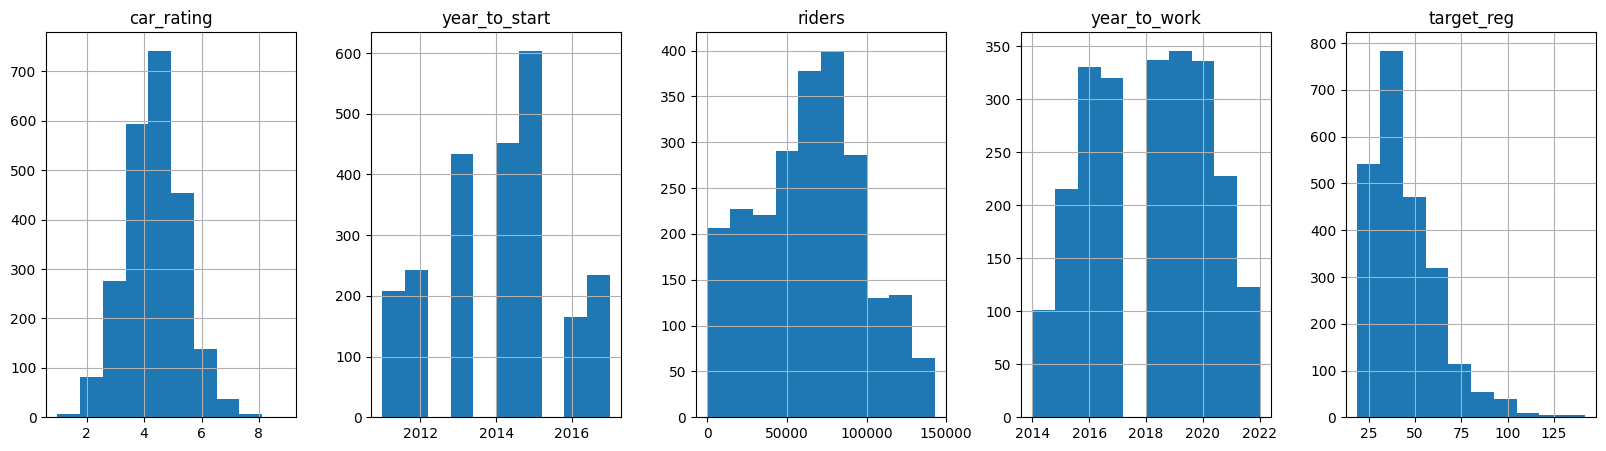

In [2]:
path = '../data/car_train.csv'
train = pd.read_csv(path)
print(train.shape)
train.hist(figsize=(20, 5), layout = (-1, 5))
train.sample(3)

In [3]:
train.describe()

,car_rating,year_to_start,riders,year_to_work,target_reg
count,2337.000000,2337.000000,2337.000000,2337.000000,2337.000000
mean,4.354292,2014.040650,63711.443731,2018.069748,44.946735
std,0.996954,1.685852,33755.012096,2.159484,17.579568
min,0.980000,2011.000000,23.000000,2014.000000,18.920000
25%,3.740000,2013.000000,41053.000000,2016.000000,31.670000
50%,4.360000,2014.000000,64415.000000,2018.000000,40.170000
75%,5.000000,2015.000000,86515.000000,2020.000000,54.790000
max,8.900000,2017.000000,142862.000000,2022.000000,141.630000


In [4]:
path = '../data/car_test.csv'
test = pd.read_csv(path)
print(test.shape)
test.sample(3)

(1913, 8)


,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work
1573,b14483061v,Smart ForTwo,economy,petrol,4.16,2013,44976,2018
360,s-1070927u,VW Tiguan,economy,petrol,4.50,2017,125666,2022
1569,N17651234L,Skoda Rapid,economy,petrol,2.28,2016,110260,2018


## Классифицируем признаки на типы

In [5]:
features2drop = ['car_id'] # то, что надо выбросить 
targets = ['target_class', 'target_reg'] # таргеты
cat_features = ['car_type', 'fuel_type', 'model'] # категориальные признаки

filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]

print('cat_features :', len(cat_features), cat_features)
print('num_features :', len(num_features), num_features)
print('targets', targets)

cat_features : 3 ['car_type', 'fuel_type', 'model']
num_features : 4 ['car_rating', 'year_to_start', 'riders', 'year_to_work']
targets ['target_class', 'target_reg']


## Обучаем Catboost и делаем прогноз на тест

In [6]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score #, mean_squared_error

In [7]:
X = train[filtered_features].drop(targets, axis=1, errors='ignore')
y = train['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = CatBoostClassifier(cat_features=cat_features)


clf.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          verbose=150, plot=False)

# инференс модели
y_pred = clf.predict(X_test)
print(f'\n Accuracy: {accuracy_score(y_test, y_pred)}')

Learning rate set to 0.109335
0:	learn: 2.1911361	test: 2.1951349	best: 2.1951349 (0)	total: 74.5ms	remaining: 1m 14s
150:	learn: 1.6539682	test: 2.2440578	best: 2.1908935 (6)	total: 2.17s	remaining: 12.2s
300:	learn: 1.2455381	test: 2.3306861	best: 2.1908935 (6)	total: 4.63s	remaining: 10.8s
450:	learn: 0.9685364	test: 2.4038621	best: 2.1908935 (6)	total: 7.49s	remaining: 9.12s
600:	learn: 0.7432300	test: 2.4962387	best: 2.1908935 (6)	total: 11.2s	remaining: 7.41s
750:	learn: 0.5835086	test: 2.5783601	best: 2.1908935 (6)	total: 14.9s	remaining: 4.95s
900:	learn: 0.4589187	test: 2.6654857	best: 2.1908935 (6)	total: 18.6s	remaining: 2.04s
999:	learn: 0.3990111	test: 2.7166606	best: 2.1908935 (6)	total: 21s	remaining: 0us

bestTest = 2.19089351
bestIteration = 6

Shrink model to first 7 iterations.

 Accuracy: 0.0876068376068376


In [8]:
test['target_class'] = clf.predict(test[filtered_features]).ravel()
test[['car_id', 'target_class']].to_csv('../subs/simple_baseline_v1.csv', index=False)
print('CSV file saved!')

CSV file saved!


## Добавим информацию про поездки из rides_info


🏇 Информация про поездки - `rides_info.csv`.  **Пояснение столбцов:**
- `user_id` / `car_id` / `ride_id` - идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` - дата поездки и рейтинг, поставленный водителем 
- `ride_duration` / `distance` / `ride_cost` -  длительность (время),  пройденное расстояние, стоимость поездки 
- `speed_avg` / `speed_max` - средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` - количество остановок (паузы) и флаг - была ли дозаправка.
- `user_ride_quality` - оценка манеры вождения машины водителя, определенная скоринговой ML системой сервиса.
- `deviation_normal` - общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы). 


In [9]:
path = '../data/rides_info.csv'
rides = pd.read_csv(path)
rides.sample(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
296092,f13513112o,U54140464j,r1q,2020-03-03,1.05,13,124,40,75.000000,1,300.334291,0,-3.097197,-37.154
266718,I15627521j,S15627573c,D1B,2020-03-20,4.52,70,764,34,78.000000,9,2115.465679,0,4.111654,10.607
387500,W91260508h,b-8098670o,a1l,2020-01-02,2.81,47,606,36,67.000000,1,1300.852934,0,-1.661866,-0.382
183395,G11543218N,N-1530212S,C1Z,2020-04-01,0.00,19510,214604,43,109.000000,2,853490.728371,0,7.362495,0.085
677749,W83193277o,v22254568R,r1e,2020-01-11,8.14,34,537,40,95.105802,1,1367.603005,0,2.322847,5.944


In [10]:
f = lambda x: x.nunique()
rides_df_gr = rides.groupby('car_id', as_index=False).agg(mean_rating = ('rating', 'mean'),
                                                   distance_sum = ('distance', 'sum'),
                                                   rating_min = ('rating', 'min'),
                                                   speed_max = ('speed_max', 'max'),
                                                   user_ride_quality_median = ('user_ride_quality', 'median'), 
                                                   deviation_normal_count = ('deviation_normal', 'count'),
                                                   user_uniq = ('user_id', f))


rides_df_gr.head(2)

,car_id,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,A-1049127W,4.255172,1.125753e+07,0.1,179.729652,-0.288229,174,172
1,A-1079539w,4.088046,1.912765e+07,0.1,184.505566,2.508746,174,173


In [11]:
def add_featues(df):
    
    if 'mean_rating' not in df.columns:
        return df.merge(rides_df_gr, on = 'car_id', how = 'left')
    
    return df
    
    
train = add_featues(train)
test = add_featues(test)

In [12]:
train.sample(2)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
218,g-2283000q,Tesla Model 3,premium,electro,5.44,2015,75113,2020,47.95,gear_stick,4.413736,1.436422e+07,0.10,101.976813,-0.650539,174,141
1525,Q13493762f,Kia Rio X-line,economy,petrol,3.52,2015,92913,2021,62.06,engine_check,4.327069,1.032370e+07,0.15,164.000000,0.632199,174,172


In [13]:
train.to_csv('../tmp_data/quickstart_train.csv', index=False)

In [14]:
test.to_csv('../tmp_data/quickstart_test.csv', index=False)

# Снова обновляем типы фичей

In [15]:
filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]


print('num_features :', len(num_features), num_features)
print('cat_features :', len(cat_features), cat_features)
print('targets', targets)

num_features : 11 ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'deviation_normal_count', 'user_uniq']
cat_features : 3 ['car_type', 'fuel_type', 'model']
targets ['target_class', 'target_reg']


# Обучаем Catboost на новых данных и делаем новый прогноз

In [16]:
X = train[filtered_features].drop(targets, axis=1, errors='ignore')
y = train['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = CatBoostClassifier(cat_features=cat_features)


clf.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          verbose=150, plot=False)

# инференс модели
y_pred = clf.predict(X_test)
print(f'\n Accuracy: {accuracy_score(y_test, y_pred)}')

Learning rate set to 0.109335
0:	learn: 1.8475119	test: 1.8655808	best: 1.8655808 (0)	total: 19.5ms	remaining: 19.5s
150:	learn: 0.3200590	test: 0.5547029	best: 0.5540463 (147)	total: 3.03s	remaining: 17s
300:	learn: 0.1971982	test: 0.5615205	best: 0.5513186 (167)	total: 6.13s	remaining: 14.2s
450:	learn: 0.1358231	test: 0.5753409	best: 0.5513186 (167)	total: 9.25s	remaining: 11.3s
600:	learn: 0.0976373	test: 0.5939145	best: 0.5513186 (167)	total: 12.4s	remaining: 8.21s
750:	learn: 0.0733795	test: 0.6068865	best: 0.5513186 (167)	total: 16.8s	remaining: 5.56s
900:	learn: 0.0574033	test: 0.6209075	best: 0.5513186 (167)	total: 21.2s	remaining: 2.33s
999:	learn: 0.0496109	test: 0.6291796	best: 0.5513186 (167)	total: 24.1s	remaining: 0us

bestTest = 0.5513186112
bestIteration = 167

Shrink model to first 168 iterations.

 Accuracy: 0.782051282051282


In [17]:
fi = clf.get_feature_importance(prettified=True)
fi

,Feature Id,Importances
0,speed_max,36.034645
1,mean_rating,30.903684
2,rating_min,13.938537
3,model,4.206258
4,car_type,3.881288
5,user_uniq,3.035950
6,user_ride_quality_median,2.097702
7,distance_sum,1.614279
8,riders,1.347984
9,car_rating,1.149331


In [18]:
test['target_class'] = clf.predict(test[filtered_features]).ravel()
test[['car_id', 'target_class']].to_csv('../subs/simple_baseline_v2.csv', index=False)
print('CSV file saved!')

CSV file saved!


# Что дальше? Зашли решение на Kaggle

- Нажимаем `Save Version`
- Проверяем, что в `Advanced Settings` выбрано - всегда сохранять результаты ноутбука.
- Тип сохранения `Save & Run All (Commit)`
- Жмем окончательно кнопку `Save`